# This spread sheet uses surface temperaturue measurements along with Other met and canopy variables and estimates of Rn G to give estimates of ET and compares with measurements

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import lmfit as fitter
import ETFunctions as et
from datetime import datetime
import matplotlib.dates as mdates
import MathsUtilities as MUte
import GraphHelpers as GH

## Bring in data

### Bring in the cover Data

Text(0,0.5,'Cover Green')

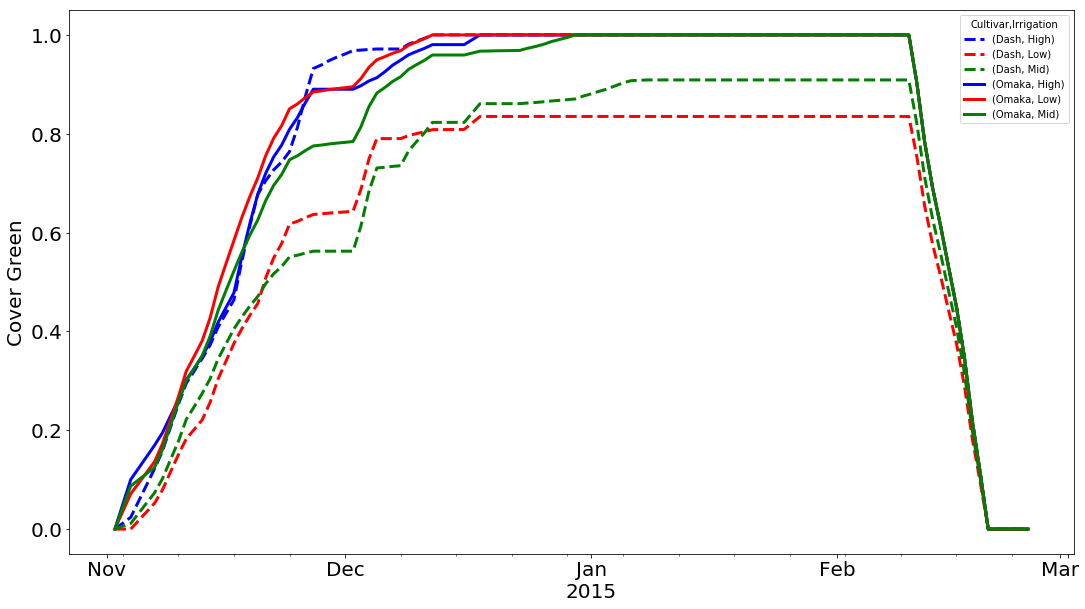

In [2]:
CoverData = pd.read_pickle('.\DataFrames\DailyFPAREstInt.pkl')
CoverData.sort_index(axis=1,inplace=True)
CoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Cover Green', fontsize = 20)

Text(0,0.5,'Cover Green')

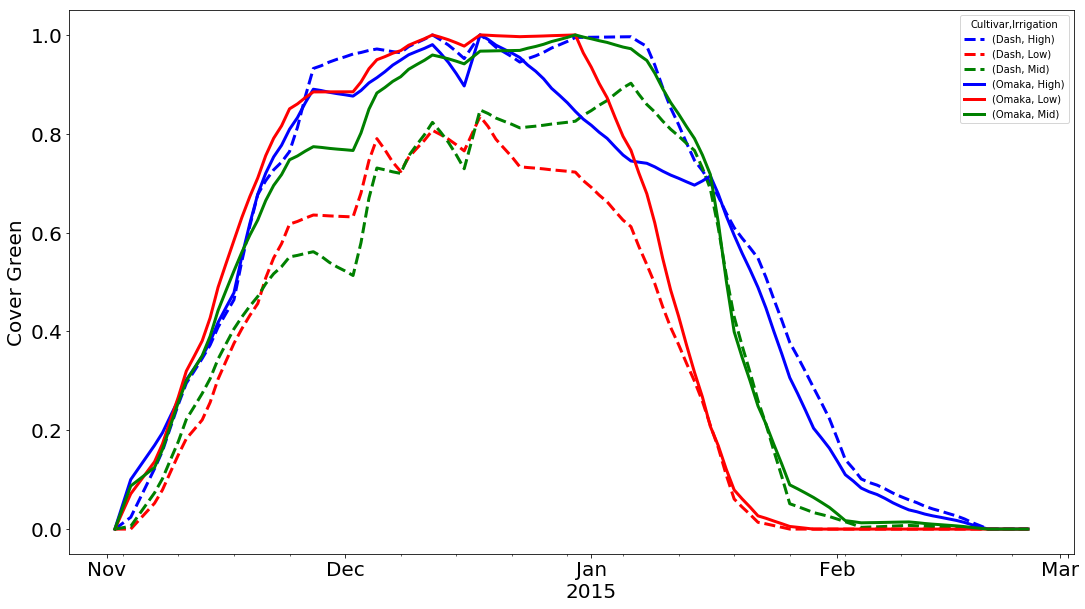

In [3]:
GreenCoverData = pd.read_pickle('.\DataFrames\FPARGreenEstimated.pkl')
GreenCoverData.sort_index(axis=1,inplace=True)
GreenCoverData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Cover Green', fontsize = 20)

Text(0,0.5,'Height')

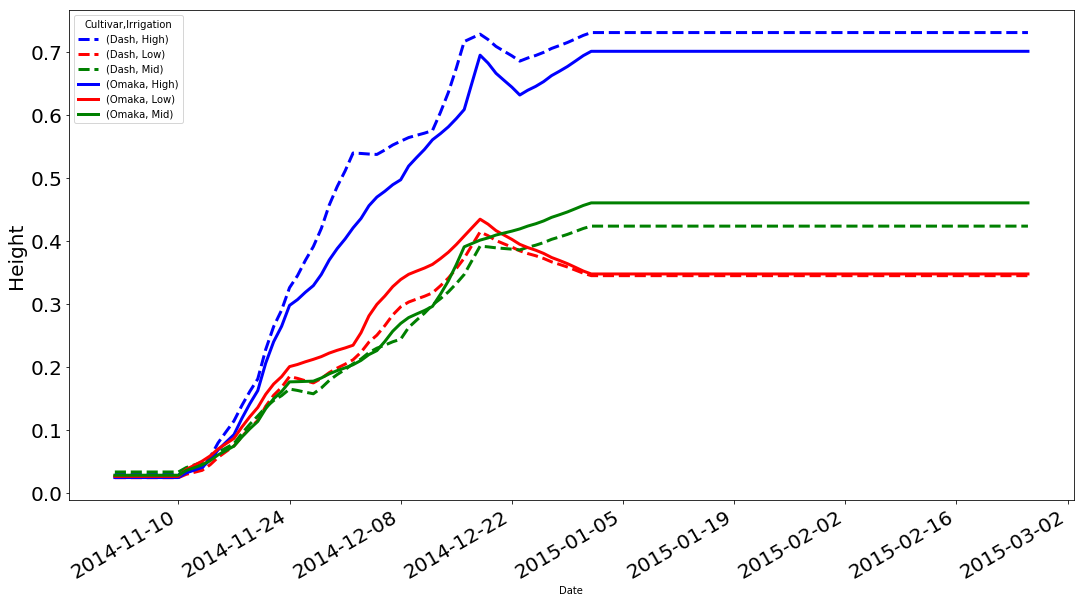

In [4]:
HeightData = pd.read_pickle('.\DataFrames\HeightEstimated.pkl')
HeightData.sort_index(axis=1,inplace=True)
HeightData.groupby(level=['Cultivar','Irrigation'],axis=1).mean().plot(fontsize = 20, figsize=(18,10),style=['b--','r--','g--','b-','r-','g-'],linewidth = 3)
plt.ylabel('Height', fontsize = 20)

In [5]:
GPs = GH.SetGraphicsPatterns(HeightData.columns,
                    ['--','-'],
                    [0.45,0.15],
                    ['^','o'],
                    ['blue','red','green'])

Cultivar
['Dash', 'Omaka']
Irrigation
['High', 'Low', 'Mid']
Treatments
MultiIndex(levels=[['Dash', 'Omaka'], ['High', 'Low', 'Mid']],
           labels=[[0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]])
Styles
[('--', 'blue', 0.45, '^'), ('--', 'red', 0.45, '^'), ('--', 'green', 0.45, '^'), ('-', 'blue', 0.15, 'o'), ('-', 'red', 0.15, 'o'), ('-', 'green', 0.15, 'o')]
StyleFrame
           Lin    Col   Alp Mar    MFC
Dash  High  --   blue  0.45   ^   blue
      Low   --    red  0.45   ^    red
      Mid   --  green  0.45   ^  green
Omaka High   -   blue  0.15   o  white
      Low    -    red  0.15   o  white
      Mid    -  green  0.15   o  white


## Bring in the Energy Balance Data

In [6]:
ECT = '2014-11-08 00:00:00'
LCT = '2015-02-11 00:00:00'
EstRn = pd.read_pickle('.\DataFrames\EstNetRadiation.pkl').loc[pd.IndexSlice[:,:,:,ECT:]]
EstG= pd.read_pickle('.\DataFrames\SoilHeatFluxDayEst.pkl')
HourlyWateruse = pd.read_pickle('.\DataFrames\HourlyWUmm.pkl').loc[ECT:,:]
HourlyWateruse.sort_index(axis=1,inplace=True)
TnRData = pd.read_pickle('.\DataFrames\TempAndMet.pkl')
TnRData.sort_index(axis=1,inplace=True)
TnRData.index.name='Date'
DayTimePET = pd.read_pickle('.\DataFrames\DayTimePET.pkl')
DayTimePET.index = DayTimePET.index.normalize()
TsULTa = pd.read_pickle('.\DataFrames\TsTaULDF.pkl')
TsLLTa = pd.read_pickle('.\DataFrames\TsTaLLDF.pkl')
Ra = pd.read_pickle('.\DataFrames\RaDF.pkl')


Albedo = 0.23
Lattitude = -43.38
LongitudeTZ = 185
LongitudeML = 360 - 172.28
Cp = 1.013 #Heat capacity of air kJoule/kg/oC

##Contract dataframes down to common index size
TnRData = TnRData.loc[ECT:LCT,:]

Irrigations = ['Low','Mid','High']
Cultivars = ['Dash','Omaka']
PlotList = [('Dash','Low','1'),('Dash','Low','2'),('Dash','Low','3'),('Dash','Low','4'),
('Dash','Mid','1'),('Dash','Mid','2'),('Dash','Mid','3'),('Dash','Mid','4'),
('Dash','High','1'),('Dash','High','2'),('Dash','High','3'),('Dash','High','4'),
('Omaka','Low','1'),('Omaka','Low','2'),('Omaka','Low','3'),('Omaka','Low','4'),
('Omaka','Mid','1'),('Omaka','Mid','2'),('Omaka','Mid','3'),('Omaka','Mid','4'),
('Omaka','High','1'),('Omaka','High','2'),('Omaka','High','3'),('Omaka','High','4')]

## Do some processing and cleaning

In [7]:
#Create a list of time to exclude where data was missing or irrigation was applied
NoMeasurementDates = ['2014-12-26','2014-12-27','2014-12-28']
IrrigationDates = ['2014-11-11','2014-11-18','2014-11-26','2014-12-02','2014-12-10','2014-12-16',
                    '2014-12-23','2014-12-30','2015-01-06','2015-01-13','2015-01-14']

ExclusionDates = IrrigationDates
for Date in NoMeasurementDates:
    ExclusionDates.append(Date)

#Exclude data from Temperature and radiation dataframe
ExclusionDateTimes5 = []
for Date in ExclusionDates:
    ExclusionDateTimes5 += pd.date_range(Date,periods=288,freq='5T')
TnRData = TnRData.loc[~TnRData.index.isin(ExclusionDateTimes5)]

# Make an index of all daylight hours in trial
HourlyTnRDataSum = TnRData.resample('h').sum()
HourlyTnRDataMean = TnRData.resample('h').mean()
DaylightIndex = HourlyTnRDataSum.loc[:,'IncomingRadnMJ'].where(HourlyTnRDataSum.loc[:,'IncomingRadnMJ']>0.02)
DaylightIndex.dropna(inplace=True)
DaylightIndex = pd.to_datetime(DaylightIndex.index)

# Make day time means and sums for temperature and radiation data
DayTimeTnRDataMean = HourlyTnRDataMean.loc[DaylightIndex].resample('d').mean()
DayTimeTnRDataSum = HourlyTnRDataSum.loc[DaylightIndex].resample('d').sum()

# Make daily (day time) ET dataframe from hourly data excluding dark periods
ET = HourlyWateruse.loc[DaylightIndex].resample('d').sum()
ET = ET.loc[~ET.index.isin(ExclusionDates)]
ET = ET*-1
ET.index.name = 'Date'

#Exclude non measurement and irrigation dates from Rn and G data frames
EstRn = EstRn.loc[~EstRn.index.isin(ExclusionDates, level=3)]
EstG = EstG.loc[~EstG.index.isin(ExclusionDates)]

#Exclude data from Surface Temperature upper limit dataframe and make daily mean
TsULTa = TsULTa.loc[~TsULTa.index.isin(ExclusionDateTimes5)]
TsLLTa = TsLLTa.loc[~TsLLTa.index.isin(ExclusionDateTimes5)]
HourlyTsULTa = TsULTa.resample('h').mean()
HourlyTsLLTa = TsLLTa.resample('h').mean()
DayTimeTsULTaMean = TsULTa.loc[DaylightIndex].resample('d').mean()
DayTimeTsLLTaMean = TsLLTa.loc[DaylightIndex].resample('d').mean()

#Exclude data from aerodynamic resistance dataframe and make daily mean
Ra = Ra.loc[~Ra.index.isin(ExclusionDateTimes5)]
HourlyRa = Ra.resample('h').mean()
DayTimeRaMean = Ra.loc[DaylightIndex].resample('d').mean()

In [8]:
def makeSeries(Var,Frame):
    SSeries= Frame.loc[Var]
    SSeries.name = Var
    SSeries.index = SSeries.index.droplevel()
    SSeries.index = SSeries.index.droplevel()
    return SSeries

In [9]:
import math as math #import library for math functions
def RaZot(WindSpeed, Zu, h, Zot_Zom):
    """Aerodynamic resistance based on wind speed as described by Maes and Stepp 2012 in sm-1
    
    Original Reference: Thom and Oliver, 1977.  On Penmans equation for estimating regaional evaporation.  J Q R Meteorological Soc 98: 124
    
    Args:
        WindSpeed in m/s
        Zu in m is the hight that wind speed and temperature are measured 
        and is 1.2 m for a standard met station
        h in m is the height of the canopy 
    """
    if WindSpeed < 1.0:
        WindSpeed = 1
    d = (0.63*h)  # is the zero displacement height which is a complex function of canopy height and archicture
    Zot = (0.13*h) * Zot_Zom # is the roughness length of temperature and is also influenced by canopy height and archicture
    LN = math.log((Zu-d)/Zot)
    _ret = math.pow(LN,2)/(0.16*WindSpeed)
    return _ret 

def RaZom(WindSpeed, Zu, h):
    """Aerodynamic resistance based on wind speed as described by Maes and Stepp 2012.  Includes an empurical adjustment
    to account for the effects of buoynacy.
    
    Original Reference: Thom and Oliver, 1977.  On Penmans equation for estimating regaional evaporation.  J Q R Meteorological Soc 98: 124
    
    Args:
        WindSpeed in m/s
        Zu in m is the hight that wind speed and temperature are measured 
        and is 1.2 m for a standard met station
        h in m is the height of the canopy 
    """
    if WindSpeed < 1.0:
        WindSpeed = 1
    d = (0.63*h)  # is the zero displacement height which is a complex function of canopy height and archicture
    Zom = (0.13*h)  # is the roughness length of momenum and is also influenced by canopy height and archicture
    LN = math.log((Zu-d)/Zom)
    _ret = math.pow(LN,2)/(0.16*WindSpeed)
    return _ret 

In [10]:
#Start off data frame with net radiation data W/m2
EstRn.name = 'EstRn'
EstEnergyBalance = pd.DataFrame(EstRn)

#Make soil heat flux data long and join into energy balance data frame
EstG.index.name='Date'
EstGLong = EstG.unstack()
EstGLong.name = 'EstG'
EstEnergyBalance = EstEnergyBalance.join(EstGLong)

#Make surface temperature data long and join into energy balance data frame
TsTa = np.subtract(DayTimeTnRDataMean.loc[:,'IR_SurfaceTemp'] , DayTimeTnRDataMean.loc[:,'AirTemperature'])
TsTaLong = TsTa.unstack()
TsTaLong.name = 'Ts-Ta'
EstEnergyBalance = EstEnergyBalance.join(TsTaLong)

#Make surface temperature limit data long and join into energy balance data frame
DayTimeTsULTaMean.index.name = 'Date'
TsULTaLong = DayTimeTsULTaMean.unstack()
TsULTaLong.name = 'TsUL-Ta'
EstEnergyBalance = EstEnergyBalance.join(TsULTaLong)
DayTimeTsLLTaMean.index.name = 'Date'
TsLLTaLong = DayTimeTsLLTaMean.unstack()
TsLLTaLong.name = 'TsLL-Ta'
EstEnergyBalance = EstEnergyBalance.join(TsLLTaLong)

#Duplicate Experiment level met data across all treatments and join into energy balance data frame
DateSet = EstEnergyBalance.loc[('Dash','Low','1'),:].index
TnRDataLong = DayTimeTnRDataMean.loc[DateSet].unstack()
LamdaSeries = makeSeries('lamda',TnRDataLong)
tempSeries = makeSeries('AirTemperature',TnRDataLong)
windSeries = makeSeries('Windspeed',TnRDataLong)
qSeries = makeSeries('q',TnRDataLong)
VPDSeries = makeSeries('VPD',TnRDataLong)
VPSeries = makeSeries('VP',TnRDataLong)
for plot in PlotList:
    EstEnergyBalance.loc[plot,'lamda'] = LamdaSeries.values
    EstEnergyBalance.loc[plot,'Ta'] = tempSeries.values
    EstEnergyBalance.loc[plot,'u'] = windSeries.values
    EstEnergyBalance.loc[plot,'q'] = qSeries.values
    EstEnergyBalance.loc[plot,'VPD'] = VPDSeries.values
    EstEnergyBalance.loc[plot,'Ea'] = VPSeries.values
    EstEnergyBalance.loc[plot,'PET'] = DayTimePET[EstEnergyBalance.loc[plot,'q'].index].values

#Join cover and green cover data into the data frame
EstEnergyBalance.loc[:,'Cover'] = CoverData.loc[DateSet].bfill().unstack()
EstEnergyBalance.loc[:,'GreenCover'] = GreenCoverData.loc[DateSet].bfill().unstack()
EstEnergyBalance.loc[:,'Height'] = HeightData.loc[DateSet].bfill().unstack()
    
IntIndex = EstEnergyBalance.index

#Calculate some other values    
EstEnergyBalance.loc[:,'qCp'] = EstEnergyBalance.loc[:,'q'] * Cp
EstEnergyBalance.loc[:,'EstRn-EstG'] = EstEnergyBalance.loc[:,'EstRn'] - EstEnergyBalance.loc[:,'EstG']
EstEnergyBalance.loc[:,'Ts'] = EstEnergyBalance.loc[:,'Ta'] + EstEnergyBalance.loc[:,'Ts-Ta']
EstEnergyBalance.loc[:,'To'] = EstEnergyBalance.loc[:,'Ts']  + 0 + EstEnergyBalance.loc[:,'VPD'] * 1
EstEnergyBalance.loc[:,'To-Ta'] =  EstEnergyBalance.loc[:,'To'] -  EstEnergyBalance.loc[:,'Ta'] 
EstEnergyBalance.loc[:,'SatVP'] = [et.saturated_vapor_pressure(EstEnergyBalance.loc[x,'Ta'])/10 for x in IntIndex]
EstEnergyBalance.loc[:,'RH'] = np.divide(EstEnergyBalance.loc[:,'Ea'],EstEnergyBalance.loc[:,'SatVP'])
EstEnergyBalance.loc[:,'RH'] = np.multiply(EstEnergyBalance.loc[:,'RH'],100)

#Make water use data long and join into energy balance dataset
ETLong = ET.unstack()
ETLong.name = 'ET'
EstEnergyBalance = EstEnergyBalance.join(ETLong)

#Find maximum daily values for ET and To across the experiment to use as potentials
PotVars = ['ET','To']
PotVarFilter = EstEnergyBalance.columns.isin(PotVars)
TreatMeans = EstEnergyBalance.loc[:,PotVarFilter].groupby(level = ['Cultivar','Irrigation','Date']).mean()
for plot in PlotList:
    EstEnergyBalance.loc[plot,'PotET'] = TreatMeans.loc[:,'ET'].groupby(level='Date').max().values
    EstEnergyBalance.loc[plot,'Top'] = TreatMeans.loc[:,'To'].groupby(level='Date').min().values

EstEnergyBalance.loc[:,'RaZot'] = [RaZot(EstEnergyBalance.loc[x,'u'],
                                  1.2 , 
                                  EstEnergyBalance.loc[x,'Height'],
                                  0.2)  for x in IntIndex] 
EstEnergyBalance.loc[:,'RaZotPot'] = [RaZot(EstEnergyBalance.loc[x,'u'],
                                  1.2 , 
                                  EstEnergyBalance.loc[x,'Height'],
                                  .2)  for x in IntIndex] 
EstEnergyBalance.loc[:,'RaZom'] = [RaZom(EstEnergyBalance.loc[x,'u'],
                                  1.2 , 
                                  EstEnergyBalance.loc[x,'Height'])for x in IntIndex]
EstEnergyBalance.loc[:,'PrystTay'] = [et.Priestly_TaylorEO(EstEnergyBalance.loc[x,'EstRn-EstG'],
                                                          EstEnergyBalance.loc[x,'Ta'],
                                                          1.23,'net') for x in IntIndex]
EstEnergyBalance.loc[:,'PenEvap'] = [et.PenmanEO(EstEnergyBalance.loc[x,'EstRn-EstG'],
                                                EstEnergyBalance.loc[x,'Ta'],
                                                EstEnergyBalance.loc[x,'u'],
                                                EstEnergyBalance.loc[x,'Ea'],
                                                'net') for x in IntIndex]
EstEnergyBalance.loc[:,'PenMon'] = [et.PenmanMonteith(EstEnergyBalance.loc[x,'EstRn-EstG'],
                                                     EstEnergyBalance.loc[x,'Ta'],
                                                     EstEnergyBalance.loc[x,'RH'],
                                                     EstEnergyBalance.loc[x,'u'],
                                                     EstEnergyBalance.loc[x,'RaZom'],
                                                     70,
                                                     86400) for x in IntIndex]

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:29: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [11]:
EstEnergyBalance.loc[('Omaka','High'),'PenMon'].groupby(level=['Date']).mean().mean()

6.01977559190375

### Calculate ET using the Delta method

In [12]:
EstEnergyBalance.loc[:,'qCP/RaZot'] = ((EstEnergyBalance.loc[:,'qCp']/1000)/EstEnergyBalance.loc[:,'RaZot']) * 86400
EstEnergyBalance.loc[:,'To-Top'] = EstEnergyBalance.loc[:,'To'] - EstEnergyBalance.loc[:,'Top']
EstEnergyBalance.loc[:,'Delta'] = (EstEnergyBalance.loc[:,'qCP/RaZot'] * EstEnergyBalance.loc[:,'To-Top'])/EstEnergyBalance.loc[:,'lamda']
GCov = [0,0.7,1]   
CovFact = [0.1,1,1]
EstEnergyBalance.loc[:,'CovFact'] = [np.interp(EstEnergyBalance.loc[x,'GreenCover'],GCov,CovFact) for x in IntIndex]
EstEnergyBalance.loc[:,'EstETDelta'] = (EstEnergyBalance.loc[:,'PenMon']- EstEnergyBalance.loc[:,'Delta'])
EstEnergyBalance.loc[:,'EstETDeltaCovCor'] = EstEnergyBalance.loc[:,'EstETDelta']*EstEnergyBalance.loc[:,'CovFact'] 

#Calculate residual
EstEnergyBalance.loc[:,'ResidualETDelta'] = EstEnergyBalance.loc[:,'ET'] - EstEnergyBalance.loc[:,'EstETDeltaCovCor']

## Calculate Naked ET

In [13]:
EstEnergyBalance.loc[:,'H'] = EstEnergyBalance.loc[:,'qCP/RaZot'] * EstEnergyBalance.loc[:,'To-Ta']
EstEnergyBalance.loc[:,'EstRn-EstG/lamda'] = EstEnergyBalance.loc[:,'EstRn-EstG'] /EstEnergyBalance.loc[:,'lamda'] 
EstEnergyBalance.loc[:,'EstETNaked'] = EstEnergyBalance.loc[:,'EstRn-EstG/lamda'] - EstEnergyBalance.loc[:,'H']/EstEnergyBalance.loc[:,'lamda']
EstEnergyBalance.loc[:,'EstETNakedCovCor'] = EstEnergyBalance.loc[:,'EstETNaked'] * EstEnergyBalance.loc[:,'CovFact'] 
#Calculate residual
EstEnergyBalance.loc[:,'ResidualETNaked'] = EstEnergyBalance.loc[:,'ET'] - EstEnergyBalance.loc[:,'EstETNakedCovCor']

## Calculate ET using Delta method with estimated Top

In [14]:
EstEnergyBalance.loc[:,'RaZotPot/qCp'] = (EstEnergyBalance.loc[:,'RaZotPot']/(EstEnergyBalance.loc[:,'qCp']/1000)) / 86400
EstEnergyBalance.loc[:,'HPot'] = EstEnergyBalance.loc[:,'EstRn-EstG']- (EstEnergyBalance.loc[:,'lamda'] * EstEnergyBalance.loc[:,'PenMon'])
EstEnergyBalance.loc[:,'EstTop-Ta'] = EstEnergyBalance.loc[:,'RaZotPot/qCp'] * EstEnergyBalance.loc[:,'HPot']
EstEnergyBalance.loc[:,'EstTop'] = EstEnergyBalance.loc[:,'Ta'] + EstEnergyBalance.loc[:,'EstTop-Ta']
EstEnergyBalance.loc[:,'To-EstTop'] = EstEnergyBalance.loc[:,'To'] - EstEnergyBalance.loc[:,'EstTop']
EstEnergyBalance.loc[:,'DeltaEstTop'] = (EstEnergyBalance.loc[:,'qCP/RaZot'] * EstEnergyBalance.loc[:,'To-EstTop'])/EstEnergyBalance.loc[:,'lamda']
EstEnergyBalance.loc[:,'EstETDeltaEstTop'] = (EstEnergyBalance.loc[:,'PenMon']- EstEnergyBalance.loc[:,'DeltaEstTop'])
EstEnergyBalance.loc[:,'EstETDeltaEstTopCovCor'] = EstEnergyBalance.loc[:,'EstETDeltaEstTop'] * EstEnergyBalance.loc[:,'CovFact']
    
#Calculate residual
EstEnergyBalance.loc[:,'ResidualETDeltaEstTop'] = EstEnergyBalance.loc[:,'ET'] - EstEnergyBalance.loc[:,'EstETDeltaEstTopCovCor']

## Calculate ET using cover correction only

In [15]:
EstEnergyBalance.loc[:,'PenMonCovCor'] = (EstEnergyBalance.loc[:,'PenMon']*EstEnergyBalance.loc[:,'CovFact'])
    
#Calculate residual
EstEnergyBalance.loc[:,'ResidualETCovCor'] = EstEnergyBalance.loc[:,'ET'] - EstEnergyBalance.loc[:,'PenMonCovCor']

## Calculate ET using the Alpha method

In [16]:
#EstEnergyBalance.loc[:,'Alpha'] = [1/(EstEnergyBalance.loc[x,'To-Ta']*0.1832+0.6852) for x in IntIndex]  
#EstEnergyBalance.loc[:,'Alpha'] = [np.exp(0.34)*np.exp(EstEnergyBalance.loc[x,'To-Ta']*-.14) for x in IntIndex]  
#EstEnergyBalance.loc[:,'Alpha'] = [np.exp(0.2663)*np.exp(EstEnergyBalance.loc[x,'To-Ta']*-.127) for x in IntIndex]  
EstEnergyBalance.loc[:,'Alpha'] = [1.3*np.exp(EstEnergyBalance.loc[x,'To-Ta']*-.13) for x in IntIndex]  
EstEnergyBalance.loc[:,'EstETAlpha'] = [et.Priestly_TaylorEO(EstEnergyBalance.loc[x,'EstRn-EstG'],EstEnergyBalance.loc[x,'Ta'],EstEnergyBalance.loc[x,'Alpha'],'net') for x in IntIndex]
GCov = [0,0.5,1]   
CovR = [-.7,0,0]
#EstEnergyBalance.loc[:,'CoverCorr'] = [np.interp(EstEnergyBalance.loc[x,'GreenCover'],GCov,CovR) for x in IntIndex]
EstEnergyBalance.loc[:,'Alpha'] = EstEnergyBalance.loc[:,'Alpha'] * EstEnergyBalance.loc[:,'CovFact']
EstEnergyBalance.loc[:,'EstETAlphaCovCor'] = [et.Priestly_TaylorEO(EstEnergyBalance.loc[x,'EstRn-EstG'],EstEnergyBalance.loc[x,'Ta'],EstEnergyBalance.loc[x,'Alpha'],'net') for x in IntIndex]
#Calculate residual
EstEnergyBalance.loc[:,'ResidualETAlpha'] = EstEnergyBalance.loc[:,'ET'] - EstEnergyBalance.loc[:,'EstETAlphaCovCor']

## Make means and graphs

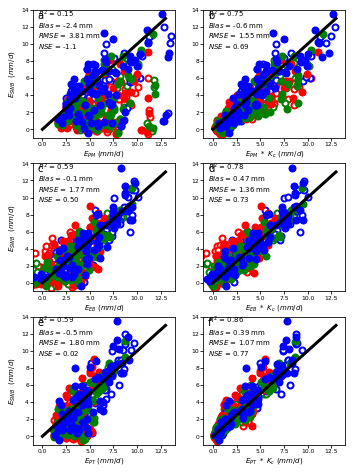

In [17]:
Irrigs = ['Low','Mid','High']
EstEBreorder = EstEnergyBalance.copy()
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Date','Cultivar')
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Irrigation','Block')
EBMeans = EstEBreorder.groupby(level=('Cultivar','Irrigation','Date'),axis=0).mean()
Estimators = ['PenMon','PenMonCovCor','EstETNaked','EstETNakedCovCor','EstETAlpha','EstETAlphaCovCor'] 
Label = [r'$E_{PM}', '$E_{PM}\ *\ K_c','$E_{EB}', '$E_{EB}\ *\ K_c','$E_{PT}', '$E_{PT}\ *\ K_c' ]
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
alphabet = ['a','b','c','d','e','f']
Comparison, axs = plt.subplots(3,2,figsize=(5.6,8))
row = 0
col = 0
pan = 0
for Est in Estimators:
    plt.sca(axs[row][col])
    culpos = 0
    for cul in Cultivars:
        irrpos = 0
        for irr in Irrigs:
            Y = EBMeans.loc[(cul,irr),'ET']#.loc['2014-11-16':'2015-01-15']
            X = EBMeans.loc[(cul,irr),Est]#.loc['2014-11-16':'2015-01-15']
            plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
            irrpos+=1
            culpos+=1
    #Make a binary filter to exclude High and Low treatments
    ValidationFilter = (EBMeans.index.isin(Irrigs,level=1))#&(EBMeans.index.get_level_values(2)<'2015-01-15')
    X = EBMeans.loc[ValidationFilter,Est] 
    Y = EBMeans.loc[ValidationFilter,'ET']
    RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
    Xs = []
    Xs.append(X.min())
    Xs.append(X.max())
    Ys = []
    Ys.append(RegStats.Intercept + Xs[0]*RegStats.Slope)
    Ys.append(RegStats.Intercept + Xs[1]*RegStats.Slope)
    #plt.plot(Xs,Ys,'-', linewidth = 3, color='brown')
    plt.plot([0,13],[0,13],'-', linewidth = 3, color='k')
    fitR2 = r'$R^2$ = ' + str(RegStats.R2)[:4]\
        + '\n$Bias$ = ' + str(RegStats.ME)[:4] + ' mm' \
        + '\n$RMSE$ = ' + str(RegStats.RMSE)[:4] + ' mm'\
        + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
    plt.text(-0.5,9.5,fitR2,fontsize=7)        
    plt.xlabel( Label[pan] +'\ (mm/d)$',fontsize=7)
    plt.tick_params(labelsize=6)
    plt.text(-0.5,13,alphabet[pan],fontsize=10)
    plt.xlim(-1,14)
    plt.ylim(-1,14)
    plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6,length = 3, direction = 'out', pad = 1)
    plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=6, length = 3, direction = 'out', pad = 1)
    axs[row][col].xaxis.labelpad = 2
    if col == 0:
        plt.ylabel('$E_{SWB}$ $\ (mm/d)$',fontsize=7)
    pan += 1
    col += 1
    if col == 2:
        col = 0
        row += 1
Comparison.savefig('Fig_7.jpg',dpi=1000)

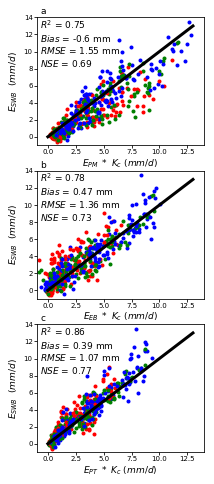

In [18]:
Irrigs = ['Low','Mid','High']
EstEBreorder = EstEnergyBalance.copy()
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Date','Cultivar')
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Irrigation','Block')
EBMeans = EstEBreorder.groupby(level=('Cultivar','Irrigation','Date'),axis=0).mean()
Estimators = ['PenMonCovCor','EstETNakedCovCor','EstETAlphaCovCor'] 
Label = ['$E_{PM}\ *\ K_c','$E_{EB}\ *\ K_c','$E_{PT}\ *\ K_c' ]
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
alphabet = ['a','b','c','d','e','f']
Comparison, axs = plt.subplots(3,1,figsize=(3,8))
row = 0
col = 0
pan = 0
for Est in Estimators:
    plt.sca(axs[row])
    culpos = 0
    for cul in Cultivars:
        irrpos = 0
        for irr in Irrigs:
            Y = EBMeans.loc[(cul,irr),'ET']#.loc['2014-11-16':'2015-01-15']
            X = EBMeans.loc[(cul,irr),Est]#.loc['2014-11-16':'2015-01-15']
            plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2,ms=2)
            irrpos+=1
            culpos+=1
    #Make a binary filter to exclude High and Low treatments
    ValidationFilter = (EBMeans.index.isin(Irrigs,level=1))#&(EBMeans.index.get_level_values(2)<'2015-01-15')
    X = EBMeans.loc[ValidationFilter,Est] 
    Y = EBMeans.loc[ValidationFilter,'ET']
    RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
    Xs = []
    Xs.append(X.min())
    Xs.append(X.max())
    Ys = []
    Ys.append(RegStats.Intercept + Xs[0]*RegStats.Slope)
    Ys.append(RegStats.Intercept + Xs[1]*RegStats.Slope)
    #plt.plot(Xs,Ys,'-', linewidth = 3, color='brown')
    plt.plot([0,13],[0,13],'-', linewidth = 3, color='k')
    fitR2 = alphabet[pan]\
        + '\n$R^2$ = ' + str(RegStats.R2)[:4]\
        + '\n$Bias$ = ' + str(RegStats.ME)[:4] + ' mm' \
        + '\n$RMSE$ = ' + str(RegStats.RMSE)[:4] + ' mm'\
        + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
    plt.text(-0.7,8.2,fitR2,fontsize=9)        
    plt.xlabel( Label[pan] +'\ (mm/d)$',fontsize=9)
    #plt.text(-0.5,13,alphabet[pan],fontsize=9)
    plt.xlim(-1,14)
    plt.ylim(-1,14)
    plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=7,length = 3, direction = 'out', pad = 1)
    plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=7, length = 3, direction = 'out', pad = 1)
    axs[row].xaxis.labelpad = 2
    plt.ylabel('$E_{SWB}$ $\ (mm/d)$',fontsize=9)
    pan += 1
#    col += 1
#    if col == 2:
#        col = 0
    row += 1
Comparison.savefig('Fig_9.jpg',dpi=1000)
Comparison.savefig('Fig_9.eps',dpi=1000)

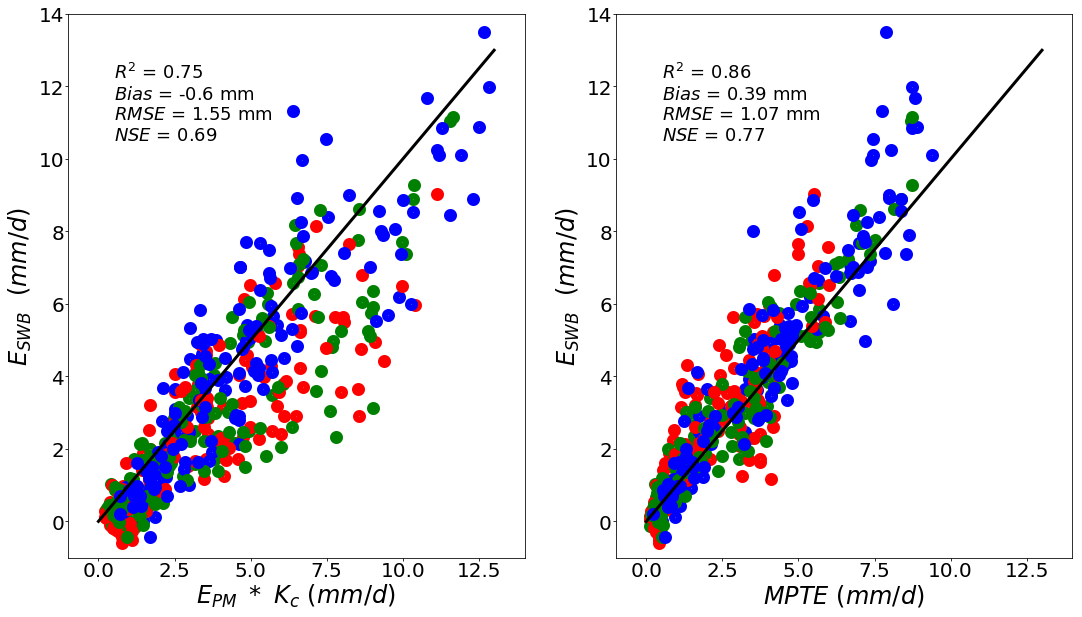

In [19]:
Irrigs = ['Low','Mid','High']
EstEBreorder = EstEnergyBalance.copy()
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Date','Cultivar')
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Irrigation','Block')
EBMeans = EstEBreorder.groupby(level=('Cultivar','Irrigation','Date'),axis=0).mean()
Estimators = ['PenMonCovCor','EstETAlphaCovCor'] 
Label = ['$E_{PM}\ *\ K_c','$MPTE' ]
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
alphabet = ['a','b','c','d','e','f']
Comparison, axs = plt.subplots(1,2,figsize=(18,10))
row = 0
col = 0
pan = 0
for Est in Estimators:
    plt.sca(axs[row])
    culpos = 0
    for cul in Cultivars:
        irrpos = 0
        for irr in Irrigs:
            Y = EBMeans.loc[(cul,irr),'ET']#.loc['2014-11-16':'2015-01-15']
            X = EBMeans.loc[(cul,irr),Est]#.loc['2014-11-16':'2015-01-15']
            plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=7)
            irrpos+=1
            culpos+=1
    #Make a binary filter to exclude High and Low treatments
    ValidationFilter = (EBMeans.index.isin(Irrigs,level=1))#&(EBMeans.index.get_level_values(2)<'2015-01-15')
    X = EBMeans.loc[ValidationFilter,Est] 
    Y = EBMeans.loc[ValidationFilter,'ET']
    RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
    Xs = []
    Xs.append(X.min())
    Xs.append(X.max())
    Ys = []
    Ys.append(RegStats.Intercept + Xs[0]*RegStats.Slope)
    Ys.append(RegStats.Intercept + Xs[1]*RegStats.Slope)
    #plt.plot(Xs,Ys,'-', linewidth = 3, color='brown')
    plt.plot([0,13],[0,13],'-', linewidth = 3, color='k')
    fitR2 = r'$R^2$ = ' + str(RegStats.R2)[:4]\
        + '\n$Bias$ = ' + str(RegStats.ME)[:4] + ' mm' \
        + '\n$RMSE$ = ' + str(RegStats.RMSE)[:4] + ' mm'\
        + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
    plt.text(0.5,10.5,fitR2,fontsize=18)        
    plt.xlabel( Label[pan] +'\ (mm/d)$',fontsize=24)
    plt.tick_params(labelsize=20)
    #plt.text(-0.5,13,alphabet[pan],fontsize=10)
    plt.xlim(-1,14)
    plt.ylim(-1,14)
    plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=20,length = 3, direction = 'out', pad = 1)
    plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=20, length = 3, direction = 'out', pad = 1)
    axs[row].xaxis.labelpad = 2
    plt.ylabel('$E_{SWB}$ $\ (mm/d)$',fontsize=24)
    pan += 1
#    col += 1
#    if col == 2:
#        col = 0
    row += 1
Comparison.savefig('Fig_7.jpg',dpi=1000)

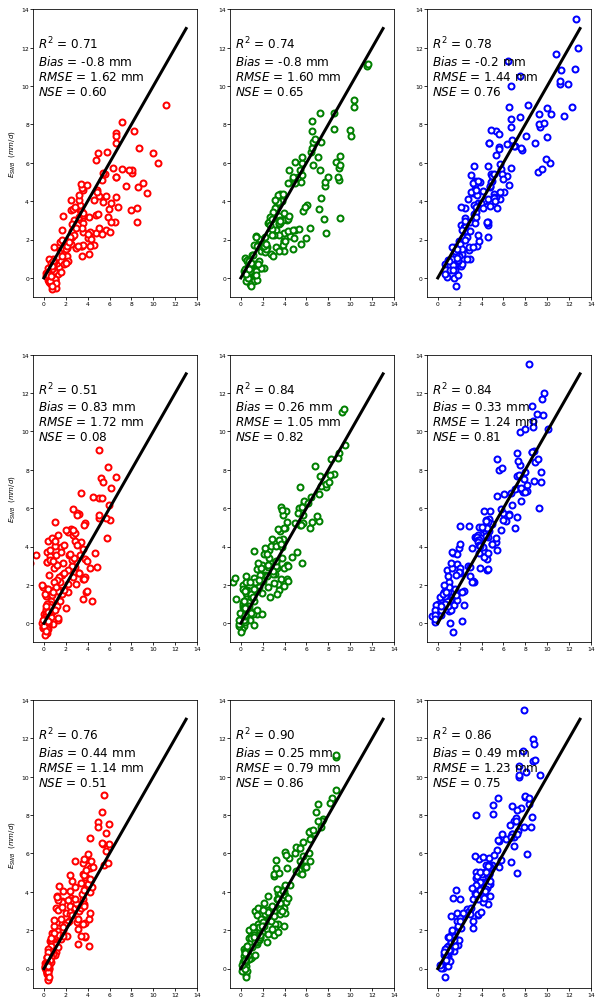

In [20]:
Irrigs = ['Low','Mid','High']
EstEBreorder = EstEnergyBalance.copy()
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Date','Cultivar')
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Irrigation','Block')
EBMeans = EstEBreorder.groupby(level=('Cultivar','Irrigation','Date'),axis=0).mean()
Estimators = ['PenMonCovCor','EstETNakedCovCor','EstETAlphaCovCor'] 
Label = ['$E_{PM}\ *\ K_c','$E_{EB}\ *\ K_c','$E_{PT}\ *\ K_c' ]
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
alphabet = ['a','b','c','d','e','f']
Comparison, axs = plt.subplots(3,3,figsize=(10,18))
row = 0
col = 0
pan = 0
for Est in Estimators:
    irrpos = 0
    for irr in Irrigs:
        plt.sca(axs[row][col])
        culpos = 0
        for cul in Cultivars:
            Y = EBMeans.loc[(cul,irr),'ET']#.loc['2014-11-16':'2015-01-15']
            X = EBMeans.loc[(cul,irr),Est]#.loc['2014-11-16':'2015-01-15']
            plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
            culpos+=1
        irrpos+=1
        #Make a binary filter to exclude High and Low treatments
        ValidationFilter = (EBMeans.index.isin([irr],level=1))#&(EBMeans.index.get_level_values(2)<'2015-01-15')
        X = EBMeans.loc[ValidationFilter,Est] 
        Y = EBMeans.loc[ValidationFilter,'ET']
        RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
        Xs = []
        Xs.append(X.min())
        Xs.append(X.max())
        Ys = []
        Ys.append(RegStats.Intercept + Xs[0]*RegStats.Slope)
        Ys.append(RegStats.Intercept + Xs[1]*RegStats.Slope)
        #plt.plot(Xs,Ys,'-', linewidth = 3, color='brown')
        plt.plot([0,13],[0,13],'-', linewidth = 3, color='k')
        fitR2 = r'$R^2$ = ' + str(RegStats.R2)[:4]\
            + '\n$Bias$ = ' + str(RegStats.ME)[:4] + ' mm' \
            + '\n$RMSE$ = ' + str(RegStats.RMSE)[:4] + ' mm'\
            + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
        plt.text(-0.5,9.5,fitR2,fontsize=12)        
        #plt.xlabel( Label[pan] +'\ (mm/d)$',fontsize=7)
        plt.tick_params(labelsize=6)
        #plt.text(-0.5,13,alphabet[pan],fontsize=10)
        plt.xlim(-1,14)
        plt.ylim(-1,14)
        plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6,length = 3, direction = 'out', pad = 1)
        plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=6, length = 3, direction = 'out', pad = 1)
        axs[row][col].xaxis.labelpad = 2
        if col == 0:
            plt.ylabel('$E_{SWB}$ $\ (mm/d)$',fontsize=7)
        pan += 1
        col += 1
        if col == 3:
            col = 0
            row += 1
Comparison.savefig('Fig_7.jpg',dpi=1000)

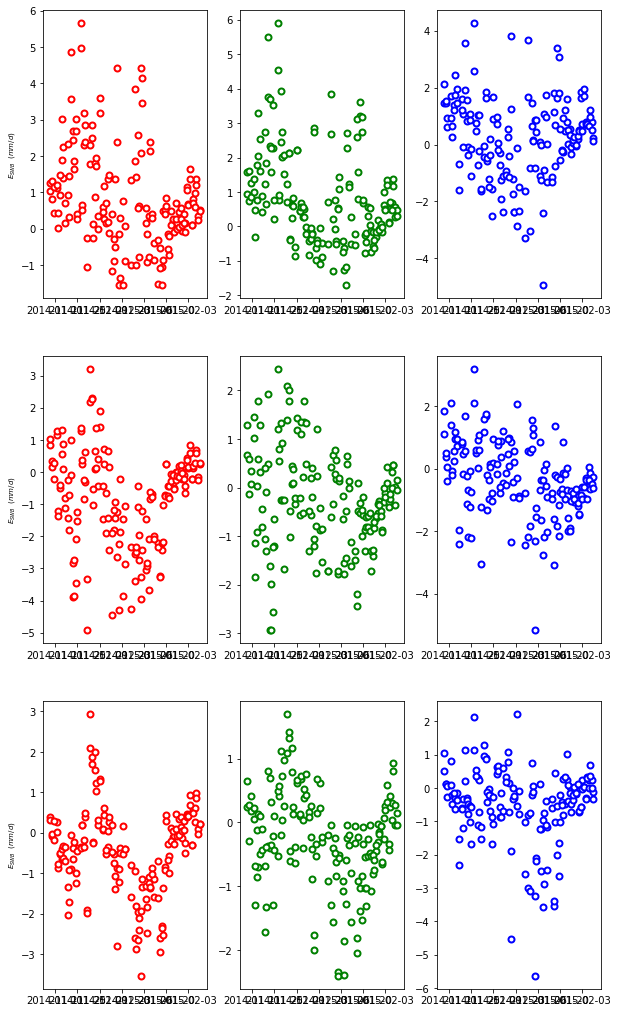

In [21]:
Irrigs = ['Low','Mid','High']
EstEBreorder = EstEnergyBalance.copy()
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Date','Cultivar')
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Irrigation','Block')
EBMeans = EstEBreorder.groupby(level=('Cultivar','Irrigation','Date'),axis=0).mean()
Estimators = ['PenMonCovCor','EstETNakedCovCor','EstETAlphaCovCor'] 
Label = ['$E_{PM}\ *\ K_c','$E_{EB}\ *\ K_c','$E_{PT}\ *\ K_c' ]
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
alphabet = ['a','b','c','d','e','f']
Comparison, axs = plt.subplots(3,3,figsize=(10,18))
row = 0
col = 0
pan = 0
for Est in Estimators:
    irrpos = 0
    for irr in Irrigs:
        plt.sca(axs[row][col])
        culpos = 0
        for cul in Cultivars:
            Y = EBMeans.loc[(cul,irr),'ET']#.loc['2014-11-16':'2015-01-15']
            X = EBMeans.loc[(cul,irr),Est]#.loc['2014-11-16':'2015-01-15']
            res = X-Y
            Xplot = EBMeans.loc[(cul,irr),'Cover'].index#.loc['2014-11-16':'2015-01-15']
            plt.plot(Xplot,res,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
            culpos+=1
        irrpos+=1
        if col == 0:
            plt.ylabel('$E_{SWB}$ $\ (mm/d)$',fontsize=7)
        pan += 1
        col += 1
        if col == 3:
            col = 0
            row += 1
Comparison.savefig('Fig_7.jpg',dpi=1000)

In [22]:
EstEnergyBalance.columns

Index(['EstRn', 'EstG', 'Ts-Ta', 'TsUL-Ta', 'TsLL-Ta', 'lamda', 'Ta', 'u', 'q',
       'VPD', 'Ea', 'PET', 'Cover', 'GreenCover', 'Height', 'qCp',
       'EstRn-EstG', 'Ts', 'To', 'To-Ta', 'SatVP', 'RH', 'ET', 'PotET', 'Top',
       'RaZot', 'RaZotPot', 'RaZom', 'PrystTay', 'PenEvap', 'PenMon',
       'qCP/RaZot', 'To-Top', 'Delta', 'CovFact', 'EstETDelta',
       'EstETDeltaCovCor', 'ResidualETDelta', 'H', 'EstRn-EstG/lamda',
       'EstETNaked', 'EstETNakedCovCor', 'ResidualETNaked', 'RaZotPot/qCp',
       'HPot', 'EstTop-Ta', 'EstTop', 'To-EstTop', 'DeltaEstTop',
       'EstETDeltaEstTop', 'EstETDeltaEstTopCovCor', 'ResidualETDeltaEstTop',
       'PenMonCovCor', 'ResidualETCovCor', 'Alpha', 'EstETAlpha',
       'EstETAlphaCovCor', 'ResidualETAlpha'],
      dtype='object')

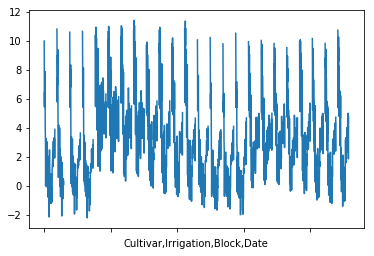

In [23]:
EstEnergyBalance.loc[:,'To-Ta'].plot()

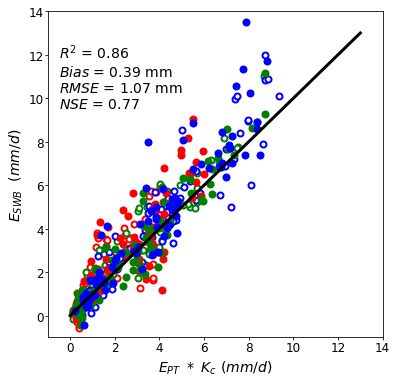

In [24]:
Irrigs = ['Low','Mid','High']
EstEBreorder = EstEnergyBalance.copy()
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Date','Cultivar')
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Irrigation','Block')
EBMeans = EstEBreorder.groupby(level=('Cultivar','Irrigation','Date'),axis=0).mean()
Estimators = ['EstETAlphaCovCor'] 
Label = ['$E_{PT}\ *\ K_c' ]
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
alphabet = ['a','b','c','d','e','f']
#Comparison, axs = plt.subplots(3,2,figsize=(5.6,8))
row = 0
col = 0
pan = 0
Comparison = plt.figure(figsize=(6,6))
culpos = 0
for cul in Cultivars:
    irrpos = 0
    for irr in Irrigs:
        Y = EBMeans.loc[(cul,irr),'ET']#.loc['2014-11-16':'2015-01-15']
        X = EBMeans.loc[(cul,irr),Est]#.loc['2014-11-16':'2015-01-15']
        plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
        irrpos+=1
        culpos+=1
#Make a binary filter to exclude High and Low reatments
ValidationFilter = (EBMeans.index.isin(Irrigs,level=1))#&(EBMeans.index.get_level_values(2)<'2015-01-15')
X = EBMeans.loc[ValidationFilter,Est] 
Y = EBMeans.loc[ValidationFilter,'ET']
RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
Xs = []
Xs.append(X.min())
Xs.append(X.max())
Ys = []
Ys.append(RegStats.Intercept + Xs[0]*RegStats.Slope)
Ys.append(RegStats.Intercept + Xs[1]*RegStats.Slope)
#plt.plot(Xs,Ys,'-', linewidth = 3, color='brown')
plt.plot([0,13],[0,13],'-', linewidth = 3, color='k')
fitR2 = r'$R^2$ = ' + str(RegStats.R2)[:4]\
    + '\n$Bias$ = ' + str(RegStats.ME)[:4] + ' mm' \
    + '\n$RMSE$ = ' + str(RegStats.RMSE)[:4] + ' mm'\
    + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
plt.text(-0.5,9.5,fitR2,fontsize=14)        
plt.xlabel( Label[pan] +'\ (mm/d)$',fontsize=14)
plt.tick_params(labelsize=6)
#plt.text(-0.5,13,alphabet[pan],fontsize=10)
plt.xlim(-1,14)
plt.ylim(-1,14)
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=12,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=12, length = 3, direction = 'out', pad = 1)
axs[row][col].xaxis.labelpad = 2
if col == 0:
    plt.ylabel('$E_{SWB}$ $\ (mm/d)$',fontsize=14)
pan += 1
col += 1
if col == 2:
    col = 0
    row += 1

In [25]:
col

1

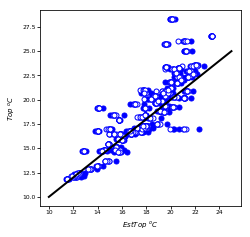

In [26]:
Fig = plt.figure(figsize=(3.6,3.6))
plt.plot(EstEnergyBalance.loc[('Omaka','High'),'EstTop'],EstEnergyBalance.loc[('Omaka','High'),'Top'],'o',markersize=5,mec='b',mfc='b',label='Omaka')
plt.plot(EstEnergyBalance.loc[('Dash','High'),'EstTop'],EstEnergyBalance.loc[('Dash','High'),'Top'],'o',markersize=5,mec='b',mfc='w', label='Dash')
plt.plot([10,25],[10,25],color='k',linewidth=2)
plt.ylabel(r'$Top\ ^oC$',fontsize=7)
plt.xlabel(r'$EstTop\ ^oC$',fontsize=7)
plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6,length = 3, direction = 'out', pad = 1)
plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=6, length = 3, direction = 'out', pad = 1)
#Fig.savefig('Fig_7.jpg',dpi=1000)

C:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Using pyplot.axes(ax) with ax an Axes argument is deprecated. Please use pyplot.sca(ax) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


KeyError: 'the label [EstETCovCor] is not in the [columns]'

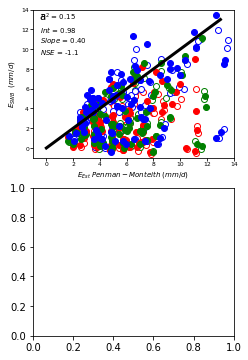

In [27]:
EstEBreorder = EstEnergyBalance.copy()
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Date','Cultivar')
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Irrigation','Block')
EBMeans = EstEBreorder.groupby(level=('Cultivar','Irrigation','Date'),axis=0).mean()
Estimators = ['PenMon','EstETCovCor'] 
Label = ['Penman-Monteith', 'P-M\ Cover\ Corrected']
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
alphabet = ['a','b','c','d','e','f']
Comparison, axs = plt.subplots(2,1,figsize=(3.6,6))
row = 0
pan = 0
for Est in Estimators:
    plt.axes(axs[row])
    culpos = 0
    for cul in Cultivars:
        irrpos = 0
        for irr in Irrigations:
            Y = EBMeans.loc[(cul,irr),'ET']#.loc['2014-11-16':'2015-01-15']
            X = EBMeans.loc[(cul,irr),Est]#.loc['2014-11-16':'2015-01-15']
            plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=1)
            irrpos+=1
            culpos+=1
    #Make a binary filter to exclude High and Low reatments
    #ValidationFilter = (EBMeans.index.isin(['Mid'],level=1))#&(EBMeans.index.get_level_values(2)<'2015-01-15')
    X = EBMeans.loc[:,Est] 
    Y = EBMeans.loc[:,'ET']
    RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
    Xs = []
    Xs.append(X.min())
    Xs.append(X.max())
    Ys = []
    Ys.append(RegStats.Intercept + Xs[0]*RegStats.Slope)
    Ys.append(RegStats.Intercept + Xs[1]*RegStats.Slope)
    #plt.plot(Xs,Ys,'-', linewidth = 3, color='brown')
    plt.plot([0,13],[0,13],'-', linewidth = 3, color='k')
    fitR2 = r'$R^2$ = ' + str(RegStats.R2)[:4]\
        + '\n$Int$ = ' + str(RegStats.Intercept)[:4] \
        + '\n$Slope$ = ' + str(RegStats.Slope)[:4]\
        + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
    plt.text(-0.5,9.5,fitR2,fontsize=7)        
    plt.xlabel(r'$E_{Est}$ $' + Label[pan] +'\ (mm/d)$',fontsize=7)
    plt.tick_params(labelsize=6)
    plt.text(-0.5,13,alphabet[pan],fontsize=10)
    plt.xlim(-1,14)
    plt.ylim(-1,14)
    plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6,length = 3, direction = 'out', pad = 1)
    plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=6, length = 3, direction = 'out', pad = 1)
    axs[row].xaxis.labelpad = 2
    plt.ylabel('$E_{SWB}$ $\ (mm/d)$',fontsize=7)
    pan += 1
    row += 1
#Comparison.savefig('Fig_9.jpg',dpi=1000)

In [ ]:
EstEBreorder = EstEnergyBalance.copy()
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Date','Cultivar')
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Irrigation','Block')
EBMeans = EstEBreorder.groupby(level=('Cultivar','Irrigation','Date'),axis=0).mean()
Estimators = ['EstETCovCor','EstETDelta'] 
Label = ['Penman-Monteith', 'P-M\ Cover\ Corrected']
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
alphabet = ['a','b','c','d','e','f']
Comparison, axs = plt.subplots(2,1,figsize=(3.6,6))
row = 0
pan = 0
for Est in Estimators:
    plt.axes(axs[row])
    culpos = 0
    for cul in Cultivars:
        irrpos = 0
        for irr in Irrigations:
            Y = EBMeans.loc[(cul,irr),'ET']#.loc['2014-11-16':'2015-01-15']
            X = EBMeans.loc[(cul,irr),Est]#.loc['2014-11-16':'2015-01-15']
            plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=1)
            irrpos+=1
            culpos+=1
    #Make a binary filter to exclude High and Low reatments
    X = EBMeans.loc[:,Est] 
    Y = EBMeans.loc[:,'ET']
    RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
    Xs = []
    Xs.append(X.min())
    Xs.append(X.max())
    Ys = []
    Ys.append(RegStats.Intercept + Xs[0]*RegStats.Slope)
    Ys.append(RegStats.Intercept + Xs[1]*RegStats.Slope)
    plt.plot([0,13],[0,13],'-', linewidth = 3, color='k')
    fitR2 = r'$R^2$ = ' + str(RegStats.R2)[:4]\
        + '\n$Int$ = ' + str(RegStats.Intercept)[:4] \
        + '\n$Slope$ = ' + str(RegStats.Slope)[:4]\
        + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
    plt.text(-0.5,9.5,fitR2,fontsize=7)        
    plt.xlabel(r'$E_{Est}$ $' + Label[pan] +'\ (mm/d)$',fontsize=7)
    plt.tick_params(labelsize=6)
    plt.text(-0.5,13,alphabet[pan],fontsize=10)
    #plt.xlim(-1,14)
    #plt.ylim(-1,14)
    plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6,length = 3, direction = 'out', pad = 1)
    plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=6, length = 3, direction = 'out', pad = 1)
    axs[row].xaxis.labelpad = 2
    plt.ylabel('$E_{SWB}$ $\ (mm/d)$',fontsize=7)
    pan += 1
    row += 1
#Comparison.savefig('Fig_9.jpg',dpi=1000)

In [ ]:
EstEBreorder = EstEnergyBalance.copy()
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Date','Cultivar')
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Irrigation','Block')
EBMeans = EstEBreorder.groupby(level=('Cultivar','Irrigation','Date'),axis=0).mean()
Estimators = ['EstETNaked','EstETDelta','EstETDeltaEstTop','EstETAlpha'] #'PenEvap','PrystTay'
Label = ['Method\ 1', 'Method\ 2', 'Method\ 3', 'Method\ 4' ]
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
alphabet = ['a','b','c','d','e','f']
Comparison, axs = plt.subplots(2,2,figsize=(5.6,5.6))
row = 0
col = 0
pan = 0
for Est in Estimators:
    plt.axes(axs[row][col])
    culpos = 0
    for cul in Cultivars:
        irrpos = 0
        for irr in Irrigations:
            Y = EBMeans.loc[(cul,irr),'ET']#.loc['2014-11-16':'2015-01-15']
            X = EBMeans.loc[(cul,irr),Est]#.loc['2014-11-16':'2015-01-15']
            plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
            irrpos+=1
            culpos+=1
    #Make a binary filter to exclude High and Low reatments
    #ValidationFilter = (EBMeans.index.isin(['Mid'],level=1))#&(EBMeans.index.get_level_values(2)<'2015-01-15')
    X = EBMeans.loc[:,Est] 
    Y = EBMeans.loc[:,'ET']
    RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
    Xs = []
    Xs.append(X.min())
    Xs.append(X.max())
    Ys = []
    Ys.append(RegStats.Intercept + Xs[0]*RegStats.Slope)
    Ys.append(RegStats.Intercept + Xs[1]*RegStats.Slope)
    #plt.plot(Xs,Ys,'-', linewidth = 3, color='brown')
    plt.plot([0,13],[0,13],'-', linewidth = 3, color='k')
    fitR2 = r'$R^2$ = ' + str(RegStats.R2)[:4]\
        + '\n$Int$ = ' + str(RegStats.Intercept)[:4] \
        + '\n$Slope$ = ' + str(RegStats.Slope)[:4]\
        + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
    plt.text(-0.5,9.5,fitR2,fontsize=7)        
    plt.xlabel(r'$E_{Est}\ ' + Label[pan] +'\ (mm/d)$',fontsize=7)
    plt.tick_params(labelsize=6)
    plt.text(-0.5,13,alphabet[pan],fontsize=10)
    plt.xlim(-4,14)
    plt.ylim(-4,14)
    plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6,length = 3, direction = 'out', pad = 1)
    plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=6, length = 3, direction = 'out', pad = 1)
    axs[row][col].xaxis.labelpad = 2
    if col == 0:
        plt.ylabel('$E_{SWB}$ $\ (mm/d)$',fontsize=7)
    pan += 1
    col += 1
    if col == 2:
        col = 0
        row = 1
#Comparison.savefig('Fig_10.jpg',dpi=1000)

In [ ]:
EstEBreorder = EstEnergyBalance.copy()
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Date','Cultivar')
EstEBreorder.index = EstEnergyBalance.index.swaplevel('Irrigation','Block')
EBMeans = EstEBreorder.groupby(level=('Cultivar','Irrigation','Date'),axis=0).mean()
Estimators = ['ResidualETNaked','ResidualETDelta','ResidualETDeltaEstTop','ResidualETAlpha'] #'PenEvap','PrystTay'
Label = ['Method\ 1', 'Method\ 2', 'Method\ 3', 'Method\ 4' ]
Colors = ['red', 'green', 'blue']
Markerfills = ['white','white','white','red', 'green', 'blue']
alphabet = ['a','b','c','d','e','f']
Comparison, axs = plt.subplots(2,2,figsize=(10.6,10.6))
row = 0
col = 0
pan = 0
for Est in Estimators:
    plt.axes(axs[row][col])
    culpos = 0
    for cul in Cultivars:
        irrpos = 0
        for irr in ['Low']:#Irrigations:
            #Y = EBMeans.loc[(cul,irr),'ET']#.loc['2014-11-16':'2015-01-15']
            Y = EBMeans.loc[(cul,irr),Est]#/EBMeans.loc[(cul,irr),'ET']#.loc['2014-11-16':'2015-01-15']
            X = EBMeans.loc[(cul,irr),'GreenCover'].index
            plt.plot(X,Y,'o',mec = Colors[irrpos],mfc=Markerfills[culpos],mew=2)
            irrpos+=1
            culpos+=1
    #Make a binary filter to exclude High and Low reatments
    #ValidationFilter = (EBMeans.index.isin(['Mid'],level=1))#&(EBMeans.index.get_level_values(2)<'2015-01-15')
#     X = EBMeans.loc[:,Est] 
#     Y = EBMeans.loc[:,'ET']
#     RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
#     Xs = []
#     Xs.append(X.min())
#     Xs.append(X.max())
#     Ys = []
#     Ys.append(RegStats.Intercept + Xs[0]*RegStats.Slope)
#     Ys.append(RegStats.Intercept + Xs[1]*RegStats.Slope)
#     #plt.plot(Xs,Ys,'-', linewidth = 3, color='brown')
#     plt.plot([0,13],[0,13],'-', linewidth = 3, color='k')
#     fitR2 = r'$R^2$ = ' + str(RegStats.R2)[:4]\
#         + '\n$Int$ = ' + str(RegStats.Intercept)[:4] \
#         + '\n$Slope$ = ' + str(RegStats.Slope)[:4]\
#         + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
#     plt.text(-0.5,9.5,fitR2,fontsize=7)        
#     plt.xlabel(r'$E_{Est}\ ' + Label[pan] +'\ (mm/d)$',fontsize=7)
#     plt.tick_params(labelsize=6)
#     plt.text(-0.5,13,alphabet[pan],fontsize=10)
    #plt.xlim(-4,14)
    plt.ylim(-10,5)
    plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6,length = 3, direction = 'out', pad = 1)
    plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=6, length = 3, direction = 'out', pad = 1)
    axs[row][col].xaxis.labelpad = 2
    if col == 0:
        plt.ylabel('$E_{SWB}$ $\ (mm/d)$',fontsize=7)
    pan += 1
    col += 1
    if col == 2:
        col = 0
        row = 1
#Comparison.savefig('Fig_10.jpg',dpi=1000)

In [ ]:
Estimators = ['EstETNaked','PenMon','PenEvap','PrystTay']
Label = ['Energy\ Balance','Penman-Monteith', 'Penman', 'Priestley-Taylor', 'Delta\ Estimated\ T_{op}', 'Alpha' ]
Colors = ['red', 'green', 'blue']
Markerfills = ['white','blue']
alphabet = ['a','b','c','d','e','f']
Comparison, axs = plt.subplots(2,2,figsize=(5.6,5.6))
row = 0
col = 0
pan = 0
for Est in Estimators:
    plt.axes(axs[row][col])
    culpos = 0
    for cul in Cultivars:
        Y = EBMeans.loc[(cul,'High'),'ET'].loc['2014-11-29':'2015-01-15']
        X = EBMeans.loc[(cul,'High'),Est].loc['2014-11-29':'2015-01-15']
        plt.plot(X,Y,'o',mec = 'b',mfc=Markerfills[culpos],mew=2, markersize=4)
        culpos+=1
    #Make a binary filter to exclude High and Low reatments
    ValidationFilter = (EBMeans.index.isin(['High'],level=1))&(EBMeans.index.isin([d.strftime('%Y-%m-%d') for d in pd.date_range('2014-11-29','2015-01-15')],level=2))
    X = EBMeans.loc[ValidationFilter,Est].dropna()
    Y = EBMeans.loc[ValidationFilter,'ET'].dropna()
    RegStats = MUte.MathUtilities.CalcRegressionStats('ET',Y,X)
    Xs = []
    Xs.append(X.min())
    Xs.append(X.max())
    Ys = []
    Ys.append(RegStats.Intercept + Xs[0]*RegStats.Slope)
    Ys.append(RegStats.Intercept + Xs[1]*RegStats.Slope)
    #plt.plot(Xs,Ys,'-', linewidth = 3, color='brown')
    plt.plot([1,13],[1,13],'-', linewidth = 3, color='k')
    fitR2 = r'$R^2$ = ' + str(RegStats.R2)[:4]\
        + '\n$Bias$ = ' + str(RegStats.ME)[:4] + ' mm' \
        + '\n$RMSE$ = ' + str(RegStats.RMSE)[:4] + ' mm'\
        + '\n$NSE$ = ' + str(RegStats.NSE)[:4] +''
    plt.text(.5,9.5,fitR2,fontsize=7)        
    plt.xlabel(r'$' + Label[pan] + '\ (mm/d)$',fontsize=7)
    plt.tick_params(labelsize=6)
    plt.text(.5,13,alphabet[pan],fontsize=10)
    #plt.xlim(-1,14)
    #plt.ylim(-1,14)
    plt.tick_params(axis='x', which='both', bottom=True,top=False, labelbottom=True,labelsize=6,length = 3, direction = 'out', pad = 1)
    plt.tick_params(axis='y', which='both', left=True,right=False, labelright=False,labelsize=6, length = 3, direction = 'out', pad = 1)
    axs[row][col].xaxis.labelpad = 2
    if col == 0:
        plt.ylabel('$E_{SWB}$ $(mm/d)$',fontsize=7)
    pan += 1
    col += 1
    if col == 2:
        col = 0
        row = 1
Comparison.savefig('Fig_8.jpg',dpi=1000)

In [ ]:
EBMeans.loc[('Dash','High'),'ET'].cumsum().plot(style='b--')
EBMeans.loc[('Omaka','High'),'ET'].cumsum().plot(style='b-')
EBMeans.loc[('Dash','Mid'),'ET'].cumsum().plot(style='g--')
EBMeans.loc[('Omaka','Mid'),'ET'].cumsum().plot(style='g-')
EBMeans.loc[('Dash','Low'),'ET'].cumsum().plot(style='r--')
EBMeans.loc[('Omaka','Low'),'ET'].cumsum().plot(style='r-')

In [ ]:
EstEnergyBalance.loc[('Dash','Low'),'To-Ta'].loc['2014-11-29':'2015-01-15']